___
### Welome to a notebook exploring bird classification.

The dataset you need to upload into your workspace can be found here: 

https://www.kaggle.com/gpiosenka/100-bird-species

Once uploaded into your working directory follow the code below for reproducable results.
Enjoy!

___
*any comments suggestions to [j.stelling2@ncl.ac.uk] *

In [1]:
# Import libraries

# python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import zipfile
import shutil
import os 

# keras and tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Set up the file structure 

In [26]:
f = zipfile.ZipFile('birds.zip', 'r')

# extract the files into a new directory called Birds:
print('starting zipfile extraction')
f.extractall('Birds')
f.close()
print('done!')

starting zipfile extraction
done!


In [4]:
os.getcwd()
os.listdir('./Birds')
#os.chdir('./j.stelling2')
#os.getcwd()

['test', 'train', 'valid']

In [3]:
# Remove the consolidated directory once we've extracted the images since we don't need it.

#os.getcwd()
#os.chdir('..')
shutil.rmtree('./Birds/consolidated')
print('done!')

done!


### Data generating and preprocessing function

In [2]:

# We can wrap ImageDataGenerator up in a function and call it for each architecture we use:
# Each architecture provides its own preprocessing and to get accurate results 
# we must preprocess the input in the same way as to how the model was trained: 


def data_generators(preprocessing): 

    # All models we consider will have this target size requirement (VGG16, VGG19, and ResNet)
    target_size=(224,224)

    train_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing) # call these two separate imagegen's to allow for adding training augmentation arguements later. 
    # Seperate test gen so we don't augment test data. 
    test_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing)


    train_dataset = train_imdatagen.flow_from_directory('birds/train',
                                            target_size= target_size, #all images should be 256x256 already but just in case
                                            class_mode= 'categorical', # changed from 'categorical' gives a label for each class from 0 - number of classes in a vector not one hot like categorical does
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=64
    )
    
    validation_dataset = train_imdatagen.flow_from_directory('birds/valid',
                                            target_size= target_size,
                                            class_mode= 'categorical',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )
    
    test_dataset = test_imdatagen.flow_from_directory('birds/test',
                                            target_size= target_size,
                                            class_mode= 'categorical',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )


    return train_dataset, validation_dataset, test_dataset

### Define a function to use for plotting our results

In [2]:
def plot_history(history, yrange):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy per epoch
    plt.subplot(1,2,1)
    plt.plot(epochs, acc,  label='Train')
    plt.plot(epochs, val_acc , label='Val')
    
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(yrange)
    plt.legend(['Train', 'Val'], loc='lower right')
    
    # Plot training and validation loss per epoch
    #plt.figure()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    
    plt.title('Classification Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    
    #plt.show()
    plt.tight_layout()

## We can visualise some images from the dataset

Found 35215 images belonging to 250 classes.


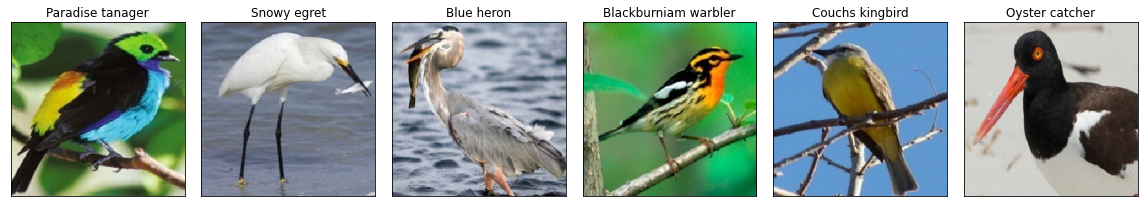

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# create a variable with the unscaled data so we can visualise it
viz_im = ImageDataGenerator()
x_viz = viz_im.flow_from_directory('birds/train', batch_size=16)

bird_dict = x_viz.class_indices
label_list = {v: k.lower().capitalize() for k, v in bird_dict.items()}
label_list


for X, y in x_viz:
    fig, ax = plt.subplots(1, 6, figsize=(16, 16))
    
    for i in range(6):
        img = X[i].astype(np.uint8)
        label = label_list[np.argmax(y[i])]

        ax[i].imshow(img)
        ax[i].set_title(label)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    
    plt.tight_layout()
    break # We only need the first batch

### Create a function for testing our models:

In [23]:
from keras.preprocessing import image
import random

print('This function will only work if the folder Birds is in your current directory as explained above!')
print('It also requires that a model has already been fitted and stored in the variable *full_model* ')

def model_tester(full_model):
    
    %matplotlib inline

    # This first part selects a random file from the validation directory
    type = random.choice(os.listdir('./Birds/valid'))
    #print(type)
    file = random.choice(os.listdir(f'./Birds/valid/{type}'))
    #print(file)

    random_path = './Birds/valid' + '/' + type + '/' + file
    #print(random_path)

    # We then create the list of labels 
    bird_dict = train_dataset.class_indices
    label_list = {v: k.lower().capitalize() for k, v in bird_dict.items()}
    label_list

    # We then select the image, preprocess and predict the values from full_model
    img_path = random_path
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    answer=full_model.predict(x)
    probability=round(np.max(full_model.predict(x)*100),2) # We could get the top n here and see if it comes in the top 5 instead of max. 
    
    # Prediction
    print ('This model suggests the image below is a: ',label_list[np.argmax(full_model.predict(x)*100)], ' with a probability of' ,probability,'%' )  # argmax pulls out the first occurence of the max arguement. This is fine for use becuase the softmax should only produce one highest value 
    
    plt.imshow(img) 
   
    # Ground Truth
    print('____________________________________')
    print('The ground truth is:  ' ,type)
    print('____________________________________\n')


    #If we want to display the next two likely outcomes we can use:
    z = full_model.predict(x)*100
    temp = np.argpartition(z[0], -3)[-3:]
    #print(temp)
    #print(z[0][temp])
    temp = np.argsort(-z[0])[:3]

    print('The two next most likely choices are: \n', 
            '          ' , label_list[temp[1]], 'with probability', round(z[0][temp][1], 2),'% \n', 
            '          ' , label_list[temp[2]], 'with probability', round(z[0][temp][2], 2), '%' )
    print('____________________________________')


This function will only work if the folder Birds is in your current directory as explained above!
It also requires that a model has already been fitted and stored in the variable *full_model* 


___
## Lets begin to construct our model.

## VGG16 

We will use transfer learning from a seminal model from the Keras library. To start with VGG16 is implemented. If undesirable results are otained we have other models available e.g. ResNet, VGG19 etc. 

The model is pre-loaded with 'imagenet' weights. 

In [5]:
# Import relavant keras libraries
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

vgg16 = keras.applications.vgg16

# When we set include_top = False we tell Keras not to include the 3 fully connected layers at the end of the model. Two dense fully connected layers with Relu 
# and one 1000 neuron softmax layer. We will construct this part ourself and end with a 250 neuron softmax for our problem.  

full_vgg16 = vgg16.VGG16(weights='imagenet', input_shape=(224, 224, 3))

full_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# Only select first conv part of vgg and remember input shape is 224,224,3   224 x244 image and 3 channels for rgb. 

conv_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, 
              input_shape=(224, 224, 3) ) # can add pooling='max' here instead of flattening for the dense layers

conv_vgg16.summary()

inputs = conv_vgg16.input
outputs = conv_vgg16.output

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Now that we have stored the first part of the network we can add a custom end to the network so that it has the abilty to classify our 250 classes of birds. 

In [7]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_vgg16.output)
# two hidden layers
x = keras.layers.Dense(2000, activation='relu')(x)
x = keras.layers.Dense(1000, activation='relu')(x)
# final softmax layer 250 classes of birds
pred_x = keras.layers.Dense(250, activation='softmax')(x)

# creating the full model:
full_model_categorical = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_x)
full_model_categorical.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### Freeze the first part of the network

In [8]:
# Since the first convolutional part has already been trained on imagenet we can freeze it and only train the last part of the network
# that we created, this will be much faster and then we can customise our layer to increase performance. 

#for layer in conv_vgg16.layers:
#    layer.trainable = False

# simply
conv_vgg16.trainable = False

# This output shows us that the parameters in the first layers arent trainable. 
full_model_categorical = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_x)
full_model_categorical.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [9]:
# Call the data_generator function to create datasets

train_dataset, validation_dataset, test_dataset = data_generators(preprocessing=vgg16.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [10]:
# Compile the model and train. # this was trained with categorical labels in the gen functions and categorical cross entropy as a loss and accuarcy as metric

full_model_categorical.compile(loss='categorical_crossentropy',  optimizer=keras.optimizers.Adam(lr=0.0001),  metrics=['accuracy'])

history_categorical = full_model_categorical.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=5 )

Epoch 1/5
551/551 [==============================] - 397s 721ms/step - loss: 3.6476 - accuracy: 0.4489 - val_loss: 1.0517 - val_accuracy: 0.7648
Epoch 2/5
551/551 [==============================] - 385s 699ms/step - loss: 0.3722 - accuracy: 0.9088 - val_loss: 0.8480 - val_accuracy: 0.8104
Epoch 3/5
551/551 [==============================] - 486s 882ms/step - loss: 0.1302 - accuracy: 0.9660 - val_loss: 0.8022 - val_accuracy: 0.8384
Epoch 4/5
551/551 [==============================] - 375s 681ms/step - loss: 0.2007 - accuracy: 0.9522 - val_loss: 1.1337 - val_accuracy: 0.8104
Epoch 5/5
551/551 [==============================] - 379s 689ms/step - loss: 0.1996 - accuracy: 0.9524 - val_loss: 1.0643 - val_accuracy: 0.8248


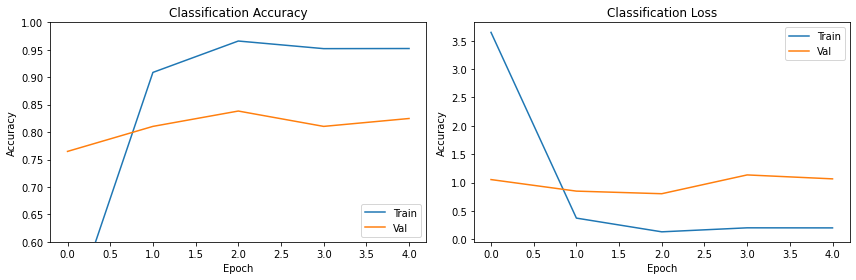

In [13]:
# Plot our results and save val_accuracy to compare in future

vgg16_train_acc_cat = history_categorical.history['accuracy']
vgg16_val_acc_cat = history_categorical.history['val_accuracy']

plot_history(history_categorical, yrange=(0.6,1))

This model suggests the image below is a:  Tasmanian hen  with a probability of 99.92 %
____________________________________
The ground truth is:   TASMANIAN HEN
____________________________________

The two next most likely choices are: 
            Steamer duck with probability 0.06 % 
            Crested caracara with probability 0.02 %
____________________________________


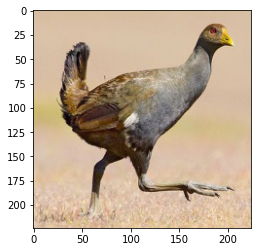

In [17]:
# Try using the function to predict:

model_tester(full_model=full_model_categorical)

### Using a sparse representation of the labels and sparse categorical cross entropy to see effects

In [34]:
# Redefine with sparse labels

def data_generators(preprocessing): 

    # All models we consider will have this target size requirement (VGG16, VGG19, and ResNet)
    target_size=(224,224)

    train_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing) # call these two separate imagegen's to allow for adding training augmentation arguements later. 
    # Seperate test gen so we don't augment test data. 
    test_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing)


    train_dataset = train_imdatagen.flow_from_directory('birds/train',
                                            target_size= target_size, #all images should be 256x256 already but just in case
                                            class_mode= 'sparse', # changed from 'categorical' gives a label for each class from 0 - number of classes in a vector not one hot like categorical does
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=64
    )
    
    validation_dataset = train_imdatagen.flow_from_directory('birds/valid',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )
    
    test_dataset = test_imdatagen.flow_from_directory('birds/test',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )


    return train_dataset, validation_dataset, test_dataset

In [9]:
# Call the data_generator function to create datasets with sparse labels

train_dataset, validation_dataset, test_dataset = data_generators(preprocessing=vgg16.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [20]:
# Redefine the model instance:

#Freeze the first layers again
conv_vgg16.trainable = False
# flatten the output of the convolutional part: 
y = keras.layers.Flatten()(conv_vgg16.output)
# two hidden layers
y = keras.layers.Dense(2000, activation='relu')(y)
y = keras.layers.Dense(1000, activation='relu')(y)
# final softmax layer 250 classes of birds
pred_y = keras.layers.Dense(250, activation='softmax')(y)

# creating the full model:
full_model_sparse = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
full_model_sparse.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [21]:
# Compile the model and train. # this was trained with sparse labels in the gen functions and sparse_categorical_crossentropy as a loss and accuarcy as metric

full_model_sparse.compile(loss='sparse_categorical_crossentropy',  optimizer=keras.optimizers.Adam(lr=0.0001),  metrics=['accuracy'])

history_sparse = full_model_sparse.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=5 )

Epoch 1/5
551/551 [==============================] - 393s 713ms/step - loss: 3.7996 - accuracy: 0.4558 - val_loss: 0.9797 - val_accuracy: 0.7656
Epoch 2/5
551/551 [==============================] - 394s 715ms/step - loss: 0.3349 - accuracy: 0.9153 - val_loss: 0.9425 - val_accuracy: 0.8008
Epoch 3/5
551/551 [==============================] - 385s 698ms/step - loss: 0.1356 - accuracy: 0.9655 - val_loss: 0.9875 - val_accuracy: 0.8048
Epoch 4/5
551/551 [==============================] - 370s 671ms/step - loss: 0.1522 - accuracy: 0.9610 - val_loss: 0.9489 - val_accuracy: 0.8256
Epoch 5/5
551/551 [==============================] - 381s 692ms/step - loss: 0.2009 - accuracy: 0.9534 - val_loss: 1.1147 - val_accuracy: 0.8208


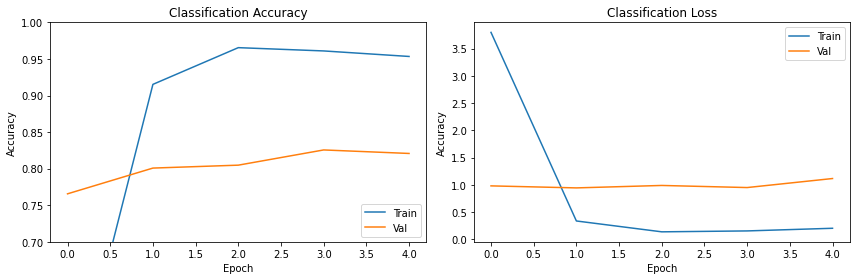

In [22]:
# Plot our results and save val_accuracy to compare in future

vgg16_sparse_train_acc = history_sparse.history['accuracy']
vgg16_sparse_val_acc = history_sparse.history['val_accuracy']

plot_history(history_sparse, yrange=(0.7,1))

This model suggests the image below is a:  Cassowary  with a probability of 100.0 %
____________________________________
The ground truth is:   CASSOWARY
____________________________________

The two next most likely choices are: 
            Ostrich with probability 0.0 % 
            Emu with probability 0.0 %
____________________________________


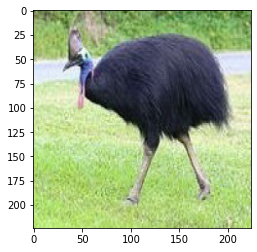

In [104]:
model_tester(full_model_sparse)

This model suggests the image below is a:  Barn swallow  with a probability of 100.0 %
____________________________________
The ground truth is:   BARN SWALLOW
____________________________________

The two next most likely choices are: 
            Eastern bluebird with probability 0.0 % 
            American redstart with probability 0.0 %
____________________________________


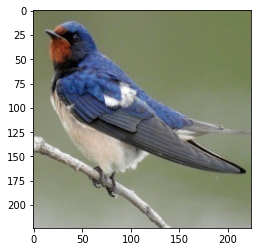

In [23]:
model_tester(full_model_sparse)

This model suggests the image below is a:  Albatross  with a probability of 100.0 %
____________________________________
The ground truth is:   ALBATROSS
____________________________________

The two next most likely choices are: 
            Go away bird with probability 0.0 % 
            Masked booby with probability 0.0 %
____________________________________


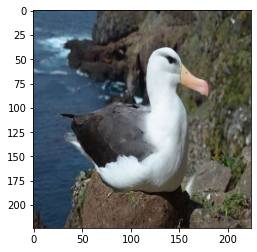

In [105]:
model_tester()

This model suggests the image below is a:  Mourning dove  with a probability of 50.15 %
____________________________________
The ground truth is:   MOURNING DOVE
____________________________________

The two next most likely choices are: 
            African firefinch with probability 36.47 % 
            Gray catbird with probability 8.97 %
____________________________________


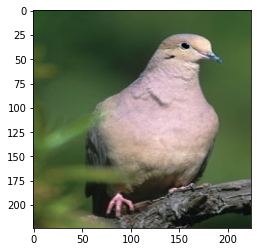

In [106]:
model_tester()

At this stage we can see that the model is working. The function above will select any random picture form the validation data and try to predict a label from the model. This is essentially in-sample validation as the model has previously been exposed to the validation data. We could do this on the test data but that could introduce bias into the model so this will be carried out at the model evaluation stage at the end. 

We see on repeat calls to the model_tester function that the model does very well for some birds and struggles on others. This could be a suggestion that image augmentation could help.

### Check ResNet out of the box and see if it performs better/faster.

We will impletement exactly the same steps as above for the **ResNet101V2** aritechture available in keras. This has considerably less parameters in the fully model with marginally better accuracy on imagenet. Once we have made the decsion what model to use we can start the model tuning. 

In [107]:
# Import resnet
from tensorflow.keras.applications import ResNet101V2


#resnet=keras.applications.ResNet101V2

conv_resnet=ResNet101V2(input_shape=(224,224,3),weights='imagenet',include_top=False)

conv_resnet.trainable = False

# inputs and outputs for functional model.
inputs = conv_resnet.input
outputs = conv_resnet.output


In [111]:
# Add our architecture on the bottom (same as before for comparison):

x = keras.layers.Flatten()(conv_resnet.output)
# two hidden layers
x = keras.layers.Dense(2000, activation='relu')(x)
x = keras.layers.Dense(1000, activation='relu')(x)
# final softmax layer 250 classes of birds
predictions = keras.layers.Dense(250, activation='softmax')(x)

# creating the full model:
full_model_resnet = keras.models.Model(inputs=conv_resnet.input, outputs=predictions)
full_model_resnet.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [109]:
# Generate data from data_generator, resnet uses vgg preprocessing. 
train_dataset, validation_dataset, test_dataset = data_generators(preprocessing=vgg16.preprocess_input)
# Generators are seeded so should have the same split.

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [113]:
# Compile the model and train. 

full_model_resnet.compile(loss='sparse_categorical_crossentropy',  optimizer=keras.optimizers.Adam(lr=0.0001),  metrics=['accuracy'])

history_resnet = full_model_resnet.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=5 )

Epoch 1/5
551/551 [==============================] - 449s 815ms/step - loss: 135.3292 - accuracy: 0.0068 - val_loss: 5.5305 - val_accuracy: 0.0032
Epoch 2/5
551/551 [==============================] - 445s 807ms/step - loss: 5.5168 - accuracy: 0.0078 - val_loss: 5.5307 - val_accuracy: 0.0064
Epoch 3/5
551/551 [==============================] - 446s 810ms/step - loss: 5.5071 - accuracy: 0.0110 - val_loss: 5.5237 - val_accuracy: 0.0080
Epoch 4/5
109/551 [====>.........................] - ETA: 5:39 - loss: 5.4902 - accuracy: 0.0148

KeyboardInterrupt: 

### ResNet doesn't seem to be performing well so we'll stick with vgg16 and perform model optimisation. 

### Add a checkpoint function to save the weights of each trained model.

In [ ]:
checkpoint_path = "./BirdCheckpoints/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, #'./' + 'TRAINING_{epoch:02d}/KAGGLE_{epoch:02d}_{val_loss:.2f}_acc:{val_accuracy:.2f}',
                             save_weights_only=True,
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

In [53]:
os.makedirs('./BirdsSavedModels')
os.makedirs('./BirdsSavedModels/WeightsOnly')
os.makedirs('./BirdsSavedModels/FullModels')

full_model_sparse.save_weights('./BirdsSavedModels/WeightsOnly/vgg16.h5')

## Regularization

We started off with a simple aritecture for the last few layers. The architecture was loosely based on the last dense layers that VGG16 has.
At this stage we could add extra dense layers in but since the architecture is quite similar to VGG we can begin to investigate the affects of regularization. 

### 1. Dropout

Dropout is an effective way to create a more robust model. It works by eliminating a random percentage of neurons from the model at each epoch thus forcing the model to pick out other features which help it classify the images. 

A gridsearch can be performed to see what dropout rate performs the best. Too high a dropout rate will be detrimental to learning whilst a rate too low with have minimal effect. We will run 3 epochs 

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation

def create_model(rate):

    conv_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3) ) 
    inputs = conv_vgg16.input
    outputs = conv_vgg16.output
    
    conv_vgg16.trainable = False

    y = keras.layers.Flatten()(conv_vgg16.output)
    y = keras.layers.Dropout(rate)(y)
    # two hidden layers
    y = keras.layers.Dense(2000, activation='relu', kernel_initializer='he_uniform')(y)
    y=  keras.layers.Dropout(rate)(y)
    y = keras.layers.Dense(1000, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.Dropout(rate)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

print('Done!')


Done!


In [40]:
# dropout_percentage = np.arange(0.20, 0.55, 0.05) too long to compute
dropout_percentage = [0.20, 0.35, 0.50]

for rate in dropout_percentage:

    print('Dropout is: ',rate*100, '%')
    model = create_model(rate)
    #model.summary()
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=3, verbose=1, workers=10)
    
    #_, train_acc = model.evaluate(train_dataset, verbose=0)
    #_, val_acc = model.evaluate(validation_dataset, verbose=0)

    #diff = train_acc - test_acc

    # Print accuracy:
    #print(f'Dropout Percentage = {rate*100:.0f}%   -   Train Accuracy: {train_acc:.3f},   Validation Accuracy: {test_acc:.3f},   Difference: {diff}')
    #print('---------------------------------')

Dropout is:  20.0 %
Epoch 1/3
551/551 [==============================] - 385s 698ms/step - loss: 8.4965 - accuracy: 0.0430 - val_loss: 4.5995 - val_accuracy: 0.1576
Epoch 2/3
551/551 [==============================] - 507s 921ms/step - loss: 3.9334 - accuracy: 0.2490 - val_loss: 1.9533 - val_accuracy: 0.5720
Epoch 3/3
551/551 [==============================] - 384s 697ms/step - loss: 2.1247 - accuracy: 0.5415 - val_loss: 0.9748 - val_accuracy: 0.7624
Dropout is:  35.0 %
Epoch 1/3
551/551 [==============================] - 386s 700ms/step - loss: 12.8090 - accuracy: 0.0152 - val_loss: 5.5119 - val_accuracy: 0.0064
Epoch 2/3
551/551 [==============================] - 428s 776ms/step - loss: 5.5902 - accuracy: 0.0113 - val_loss: 5.4951 - val_accuracy: 0.0088
Epoch 3/3
551/551 [==

We can see that with the high dropout value the model struggles to learn. Although time prohibits us to increase the epochs we would expect the model to learn in the presence of higher dropouts over time. 

We see that a rate of 20% does help overfitting by reducing the training accuracy, interestingly the validation accuracy is higher than the training accuracy. To eliminate bias we created a new model instance defined by the create_model() function at each iteration of the loop. Results suggest we include a dropout of 20% of the neurons in our model for the final dense layers we created. 



### 2. Ridge and LASSO penalties.

In [41]:
# Function to create the model this time experimenting with regularization:
# We have removed the dropout levels for quicker learning in the 3 epochs due to time constraints. 
# Once a optimal penalty is reached we can add them both into a final model. 

def create_model(lambda_value):

    conv_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3) ) 
    inputs = conv_vgg16.input
    outputs = conv_vgg16.output
    
    conv_vgg16.trainable = False

    y = keras.layers.Flatten()(conv_vgg16.output)

    # two hidden layers
    y = keras.layers.Dense(2000, activation='relu', kernel_initializer='he_uniform' ,activity_regularizer=tf.keras.regularizers.l1(lambda_value))(y)

    y = keras.layers.Dense(1000, activation='relu', kernel_initializer='he_uniform' ,activity_regularizer=tf.keras.regularizers.l1(lambda_value))(y)

    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

print('Done!')


Done!


### LASSO

In [42]:
# We can wrap this up in a for loop and inspect which lambda value works best:

# Coefficient of penatly term
# Previous experience leads to a search in the vacinity of 0.01 
lambda_value=[1e-3, 1e-2, 0.1]


for lam in lambda_value:

    print('LASSO Regularisation:   Penalty Hyperparameter=',lam)
    model = create_model(lam)
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=4, verbose=1, workers=10)


LASSO Regularisation:   Penalty Hyperparameter= 0.001
Epoch 1/4
551/551 [==============================] - 393s 713ms/step - loss: 6.2391 - accuracy: 0.2877 - val_loss: 2.9104 - val_accuracy: 0.6248
Epoch 2/4
551/551 [==============================] - 480s 872ms/step - loss: 2.1088 - accuracy: 0.8044 - val_loss: 2.0168 - val_accuracy: 0.7864
Epoch 3/4
551/551 [==============================] - 493s 895ms/step - loss: 1.2909 - accuracy: 0.9537 - val_loss: 1.7909 - val_accuracy: 0.7976
Epoch 4/4
551/551 [==============================] - 426s 774ms/step - loss: 0.9644 - accuracy: 0.9853 - val_loss: 1.6610 - val_accuracy: 0.8016
LASSO Regularisation:   Penalty Hyperparameter= 0.01
Epoch 1/4
551/551 [==============================] - 396s 718ms/step - loss: 7.4390 - accuracy: 0.0077 - val_loss: 5.5277 - val_accuracy: 0.0040

### Ridge Regression

In [43]:
def create_model(lambda_value):

    conv_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3) ) 
    inputs = conv_vgg16.input
    outputs = conv_vgg16.output
    
    conv_vgg16.trainable = False

    y = keras.layers.Flatten()(conv_vgg16.output)

    # two hidden layers
    y = keras.layers.Dense(2000, activation='relu', kernel_initializer='he_uniform' ,activity_regularizer=tf.keras.regularizers.l2(lambda_value))(y)

    y = keras.layers.Dense(1000, activation='relu', kernel_initializer='he_uniform' ,activity_regularizer=tf.keras.regularizers.l2(lambda_value))(y)

    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

print('Done!')

Done!


In [44]:
# We can wrap this up in a for loop and inspect which lambda value works best:

# Coefficient of penatly term
# Previous results from l1 study above leads to a search in the vacinity of 0.001 and 0.1
lambda_value=[0.001, 0.0025, 0.005]


for lam in lambda_value:

    print('Ridge Regularisation:   Penalty Hyperparameter=',lam)
    model = create_model(lam)
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=4, verbose=1, workers=10)


Ridge Regularisation:   Penalty Hyperparameter= 0.001
Epoch 1/4
551/551 [==============================] - 466s 846ms/step - loss: 8.1179 - accuracy: 0.0104 - val_loss: 5.5086 - val_accuracy: 0.0184
Epoch 2/4
551/551 [==============================] - 590s 1s/step - loss: 5.4718 - accuracy: 0.0315 - val_loss: 5.4428 - val_accuracy: 0.0320
Epoch 3/4
551/551 [==============================] - 392s 712ms/step - loss: 5.4377 - accuracy: 0.0462 - val_loss: 5.4312 - val_accuracy: 0.0336
Epoch 4/4
551/551 [==============================] - 420s 763ms/step - loss: 5.4190 - accuracy: 0.0444 - val_loss: 5.3939 - val_accuracy: 0.0448
Ridge Regularisation:   Penalty Hyperparameter= 0.0025
Epoch 1/4
551/551 [==============================] - 367s 666ms/step - loss: 11.2770 - accuracy: 0.0077 - val_loss: 5.5238 - val_accuracy: 0.0048

Its surprising how different the results are for lasso and ridge regression. I'm curious whether something else was at play here. Regardless from the results obtained we will implement a LASSO penalty with hyperparameter lambda = 0.001.

### Batch Normalisation:

We can add a batch normalisation layer into our model. This layer will transform inputs so they are standardised (normal transformation: location=0, scale=1) This does allow for further hyperparameters that we wont explore in this notebook, the momentum parameter can be controlled but we will take the default of 0.99 meaning that it has a memory of the statistics from the previous batch of data. The original paper suggested using batch normalisation before the activation function for that layer but successful results have now been obtain from both before and after. We we will explore the results of positioning it after the activation function.

To test whether the presence of the batch normalisation adds anything we wil take the example of running 3 epochs with dropout rate 0.2 and comparing to the corresponding dropout gridsearch results above.  

In [45]:
def create_model():

    conv_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3) ) 
    inputs = conv_vgg16.input
    outputs = conv_vgg16.output
    
    conv_vgg16.trainable = False

    y = keras.layers.Flatten()(conv_vgg16.output)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.2)(y)
    # two hidden layers
    y = keras.layers.Dense(2000, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.2)(y)
    y = keras.layers.Dense(1000, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.2)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

print('Done!')

Done!


In [47]:
print('Model metrics with Batch Normalisation:')
    
model = create_model()
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=3, verbose=1, workers=10)

Model metrics with Batch Normalisation:
Epoch 1/3
551/551 [==============================] - 411s 747ms/step - loss: 2.4476 - accuracy: 0.5100 - val_loss: 0.5248 - val_accuracy: 0.8784
Epoch 2/3
551/551 [==============================] - 392s 711ms/step - loss: 0.3445 - accuracy: 0.9443 - val_loss: 0.3522 - val_accuracy: 0.9184
Epoch 3/3
551/551 [==============================] - 390s 708ms/step - loss: 0.0955 - accuracy: 0.9927 - val_loss: 0.3048 - val_accuracy: 0.9240


We notice from the output with batch normalisation that it has a great affect on bringing the validation accuracy up. I'm actually very surprised, especially with the low number of epochs!

Try this again but this time lets increase the dropout to 0.25 to try and close the gap between training and validation accuracy:

In [48]:
def create_model():

    conv_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3) ) 
    inputs = conv_vgg16.input
    outputs = conv_vgg16.output
    
    conv_vgg16.trainable = False

    y = keras.layers.Flatten()(conv_vgg16.output)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.25)(y)
    # two hidden layers
    y = keras.layers.Dense(2000, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.25)(y)
    y = keras.layers.Dense(1000, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.25)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

print('Done!')

Done!


In [49]:
print('Model metrics with Batch Normalisation and increased dropout to 0.25:')
    
model = create_model()
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=3, verbose=1, workers=10)

Model metrics with Batch Normalisation and increased dropout to 0.25:
Epoch 1/3
551/551 [==============================] - 381s 692ms/step - loss: 2.7134 - accuracy: 0.4573 - val_loss: 0.5698 - val_accuracy: 0.8824
Epoch 2/3
551/551 [==============================] - 393s 712ms/step - loss: 0.4943 - accuracy: 0.9091 - val_loss: 0.3334 - val_accuracy: 0.9328
Epoch 3/3
551/551 [==============================] - 391s 710ms/step - loss: 0.1543 - accuracy: 0.9821 - val_loss: 0.2813 - val_accuracy: 0.9352


So far all tests have been performed on the same set of data created by one instance from the data generators performed in the same session - alleviating any potential cross comparison bias. Research into the seeds within the flow from directory command have caused some programmers issues with datasets not being reproducible. See [here](https://stackoverflow.com/questions/54164339/keras-seeding-imagedatagenerator-versus-sequence) for more details.  

In [50]:
## Testing the dropout, batch regularisation and LASSO penalty together:

def create_model():

    conv_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3) ) 
    inputs = conv_vgg16.input
    outputs = conv_vgg16.output
    
    conv_vgg16.trainable = False

    y = keras.layers.Flatten()(conv_vgg16.output)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.25)(y)
    # two hidden layers
    y = keras.layers.Dense(2000, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(0.001))(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.25)(y)
    y = keras.layers.Dense(1000, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(0.001))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.25)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

In [51]:
print('Model metrics with Batch Normalisation, dropout at 0.25 and LASSO penalty added:')
    
model = create_model()
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=3, verbose=1, workers=10)

Model metrics with Batch Normalisation, dropout at 0.25 and LASSO penalty added:
Epoch 1/3
551/551 [==============================] - 379s 688ms/step - loss: 4.8735 - accuracy: 0.4529 - val_loss: 2.6525 - val_accuracy: 0.8808
Epoch 2/3
551/551 [==============================] - 382s 693ms/step - loss: 2.5532 - accuracy: 0.9096 - val_loss: 2.0804 - val_accuracy: 0.9136
Epoch 3/3
551/551 [==============================] - 442s 803ms/step - loss: 1.7179 - accuracy: 0.9770 - val_loss: 1.5102 - val_accuracy: 0.9144


The LASSO term has restricted the training accuracy which has limited overfitting but also has affected our validation accuracy. 

The next steps are going to be to introduce augmentation which will diversity the training data. We will run for longer epochs so the limitation impose by the LASSO term might be beneficial even with the reduction in accuracy.

First we will test the effect of increasing the dropout from 20% to 30%.

In [8]:
## Testing the dropout, batch regularisation and LASSO penalty together:

def create_model():

    conv_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3) ) 
    inputs = conv_vgg16.input
    outputs = conv_vgg16.output
    
    conv_vgg16.trainable = False

    y = keras.layers.Flatten()(conv_vgg16.output)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(2000, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(0.001))(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(1000, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(0.001))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    return model

In [10]:
print('Model metrics with Batch Normalisation, dropout at 0.30 and LASSO penalty added:')
    
model = create_model()
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=3, verbose=1, workers=10)

Model metrics with Batch Normalisation, dropout at 0.30 and LASSO penalty added:
Epoch 1/3
551/551 [==============================] - 437s 793ms/step - loss: 5.2108 - accuracy: 0.4014 - val_loss: 2.7719 - val_accuracy: 0.8544
Epoch 2/3
551/551 [==============================] - 427s 775ms/step - loss: 2.8715 - accuracy: 0.8601 - val_loss: 2.1943 - val_accuracy: 0.9112
Epoch 3/3
551/551 [==============================] - 402s 730ms/step - loss: 2.0253 - accuracy: 0.9581 - val_loss: 1.6167 - val_accuracy: 0.9128


In [15]:
model.save_weights('./BirdsSavedModels/WeightsOnly/beforeAugment.h5')

The regularisation terms are doing well to keep the training accuracy down to prevent overfitting. We will keep this set-up and explore image augmentation. 

## Image Augmentation

Image augmentation allows us to produce a more robust model capable of dealing with more nuances between images. We can specify a number of augmentations to the training data so the model can learn on a more varied pool of images. We explore rotations, zooming, contrast settings, shifting and flipping images in the next section. 

At this stage we will update the model with our regularisation results and run for a longer number of epochs. After this the model weights will be saved for future use. 

In [47]:
# Redefine our generator functions:

def data_generators(preprocessing): 

    # All models we consider will have this target size requirement (VGG16, VGG19, and ResNet)
    target_size=(224,224)

    # define two separate imagegen's to allow for adding training augmentation arguements later.
    train_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing,
                                           brightness_range=[0.5,1.0], # this isnt too important since we arent dealing with images at dusk or dawn for the most part.
                                           zoom_range=[0.5,1.0],
                                           horizontal_flip=True,
                                           height_shift_range=0.5,
                                           rotation_range=90 , 
                                            ) 
    
    
    # Seperate test gen so we don't augment test data. 
    test_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing)


    train_dataset = train_imdatagen.flow_from_directory('birds/train',
                                            target_size= target_size, #all images should be 224x224 already but just in case
                                            class_mode= 'sparse', # changed from 'categorical' gives a label for each class from 0 - number of classes in a vector not one hot like categorical does
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=64
    )
    
    validation_dataset = test_imdatagen.flow_from_directory('birds/valid',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )
    
    test_dataset = test_imdatagen.flow_from_directory('birds/test',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )


    return train_dataset, validation_dataset, test_dataset

In [44]:
from keras import metrics

# Redefine the updated model with our dropout rate of 0.3 and LASSO penalty of 0.0001.


def create_model():

    conv_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3) ) 
    inputs = conv_vgg16.input
    outputs = conv_vgg16.output
    
    conv_vgg16.trainable = False

    y = keras.layers.Flatten()(conv_vgg16.output)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(2000, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(0.001))(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(1000, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(0.001))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
    #model.summary()

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optim, 
                  metrics=['accuracy'])
    
    return model

In [45]:
# Call the data_generator function to create datasets with sparse labels

train_dataset, validation_dataset, test_dataset = data_generators(preprocessing=vgg16.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [ ]:
#Training pipeline:
#
#         +-> training set ---> data augmentation --+
#          |                                         |
#          |                                         +-> model training --+
#          |                                         |                    |
#all data -+-> validation set -----------------------+                    |
#          |                                                              +-> model testing
#          |                                                              |
#          |                                                              |
#          +-> test set --------------------------------------------------+

In [49]:
full_model = create_model()
full_model.load_weights('./BirdsSavedModels/WeightsOnly/beforeAugment.h5')

# Fit our trained model with image augmentation. Increase Epochs
history_augment = full_model.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=10)

full_model.save_weights('./BirdsSavedModels/WeightsOnly/afterAugment.h5')
full_model.save('./BirdsSavedModels/FullModels/afterAugment.h5')

print('Saved Model!')

Epoch 1/10
551/551 [==============================] - 401s 728ms/step - loss: 4.8842 - accuracy: 0.2617 - val_loss: 2.7183 - val_accuracy: 0.9096
Epoch 2/10
551/551 [==============================] - 393s 712ms/step - loss: 4.0874 - accuracy: 0.3598 - val_loss: 2.6032 - val_accuracy: 0.9104
Epoch 3/10
551/551 [==============================] - 404s 733ms/step - loss: 3.6940 - accuracy: 0.4008 - val_loss: 2.4438 - val_accuracy: 0.9088
Epoch 4/10
551/551 [==============================] - 393s 713ms/step - loss: 3.4619 - accuracy: 0.4294 - val_loss: 2.3149 - val_accuracy: 0.9120
Epoch 5/10
551/551 [==============================] - 392s 711ms/step - loss: 3.2891 - accuracy: 0.4459 - val_loss: 2.2395 - val_accuracy: 0.9120
Epoch 6/10
551/551 [==============================] - 417s 757ms/step - loss: 3.

In [ ]:
plot_history(history=history_augment, yrange=(0.5,1))

Training the model on higher number of epochs would allow for a better accuracy, although it does seem to be plateauing. It seems like too much augmentations has occured here distorting the datset too much and prohibiting effective learning. We will reduce the amount of augmentation to maybe flip and zoom. (Update: Although we experienced an increase using flip and zoom it is still prohibiting learning giving an accuracy of around 80% training 92% validation, so a modification was made to only apply a horizontal flip and reduce epochs to 5 when the learning plateaus.)

We will retrain with reduced augmentation but we can still load the weights in which we have from the previous run. 

In [53]:
# Redefine our generator functions:

def data_generators(preprocessing): 

    # All models we consider will have this target size requirement (VGG16, VGG19, and ResNet)
    target_size=(224,224)

    # define two separate imagegen's to allow for adding training augmentation arguements later.
    train_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing,
                                           horizontal_flip =True ) 
    
    
    # Seperate test gen so we don't augment test data. 
    test_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing)


    train_dataset = train_imdatagen.flow_from_directory('birds/train',
                                            target_size= target_size, #all images should be 224x224 already but just in case
                                            class_mode= 'sparse', # changed from 'categorical' gives a label for each class from 0 - number of classes in a vector not one hot like categorical does
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=64
    )
    
    validation_dataset = test_imdatagen.flow_from_directory('birds/valid',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )
    
    test_dataset = test_imdatagen.flow_from_directory('birds/test',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )


    return train_dataset, validation_dataset, test_dataset

In [54]:
# Call the data_generator function to create datasets with sparse labels

train_dataset, validation_dataset, test_dataset = data_generators(preprocessing=vgg16.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [55]:
full_model = create_model()
full_model.load_weights('./BirdsSavedModels/WeightsOnly/beforeAugment.h5')

# Fit our trained model with image augmentation. Increase Epochs
history_augment = full_model.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=5)

full_model.save_weights('./BirdsSavedModels/WeightsOnly/afterAugment2.h5')
full_model.save('./BirdsSavedModels/FullModels/afterAugment2.h5')

print('Saved Model!')

Epoch 1/5
551/551 [==============================] - 391s 709ms/step - loss: 1.8316 - accuracy: 0.8741 - val_loss: 1.2905 - val_accuracy: 0.9304
Epoch 2/5
551/551 [==============================] - 375s 680ms/step - loss: 1.4042 - accuracy: 0.9124 - val_loss: 1.1094 - val_accuracy: 0.9256
Epoch 3/5
551/551 [==============================] - 375s 681ms/step - loss: 1.1571 - accuracy: 0.9296 - val_loss: 0.9838 - val_accuracy: 0.9288
Epoch 4/5
551/551 [==============================] - 391s 709ms/step - loss: 0.9791 - accuracy: 0.9391 - val_loss: 0.8911 - val_accuracy: 0.9256
Epoch 5/5
551/551 [==============================] - 389s 707ms/step - loss: 0.8540 - accuracy: 0.9426 - val_loss: 0.8407 - val_accuracy: 0.9192
Saved Model!


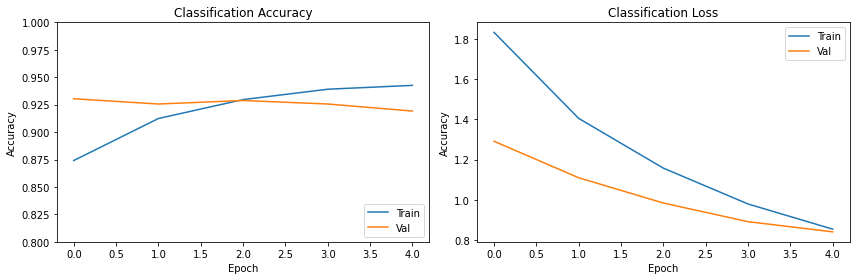

In [57]:
plot_history(history=history_augment, yrange=(0.8,1))

## Unfreezing the whole network and training it all

We will also decrease the learning rate slightly in this stage of training. The model is already quite good so we need to take smaller steps on the loss surface to ensure descent. 


In [9]:
# Import relavant keras libraries
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation

vgg16 = keras.applications.vgg16

def create_model_with_weights(weights_path):

    conv_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3) ) 
    inputs = conv_vgg16.input
    outputs = conv_vgg16.output
    
    conv_vgg16.trainable = True

    y = keras.layers.Flatten()(conv_vgg16.output)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(2000, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(0.001))(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(1000, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(0.001))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
    #model.summary()

    model.load_weights(weights_path)

    optim = keras.optimizers.Adam(lr=0.00001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optim, 
                  metrics=['accuracy'])
    
    return model

In [10]:
# Must reduce batch size when training full network to avoide OOM error

# Redefine our generator functions:

def data_generators(preprocessing): 

    # All models we consider will have this target size requirement (VGG16, VGG19, and ResNet)
    target_size=(224,224)

    # define two separate imagegen's to allow for adding training augmentation arguements later.
    train_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing,
                                           horizontal_flip =True )  
    
    
    # Seperate test gen so we don't augment test data. 
    test_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing)


    train_dataset = train_imdatagen.flow_from_directory('birds/train',
                                            target_size= target_size, #all images should be 224x224 already but just in case
                                            class_mode= 'sparse', # changed from 'categorical' gives a label for each class from 0 - number of classes in a vector not one hot like categorical does
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32
    )
    
    validation_dataset = test_imdatagen.flow_from_directory('birds/valid',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )
    
    test_dataset = test_imdatagen.flow_from_directory('birds/test',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )


    return train_dataset, validation_dataset, test_dataset

In [11]:
# Call the data_generator function to create datasets with sparse labels

train_dataset, validation_dataset, test_dataset = data_generators(preprocessing=vgg16.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [12]:
full_model = create_model_with_weights('./BirdsSavedModels/FullModels/afterAugment2.h5')

# Fit our trained model with image augmentation. Increase Epochs
history_Whole_Network = full_model.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=3)

full_model.save_weights('./BirdsSavedModels/WeightsOnly/Whole_Network_Trained1.h5')
full_model.save('./BirdsSavedModels/FullModels/Whole_Network_Trained1.h5')

print('Saved Model!')

Epoch 1/3
1101/1101 [==============================] - 974s 884ms/step - loss: 1.4926 - accuracy: 0.7367 - val_loss: 0.9983 - val_accuracy: 0.8680
Epoch 2/3
1101/1101 [==============================] - 967s 878ms/step - loss: 1.3106 - accuracy: 0.7865 - val_loss: 0.9655 - val_accuracy: 0.8808
Epoch 3/3
1101/1101 [==============================] - 969s 880ms/step - loss: 1.4566 - accuracy: 0.7504 - val_loss: 0.8945 - val_accuracy: 0.9112
Saved Model!


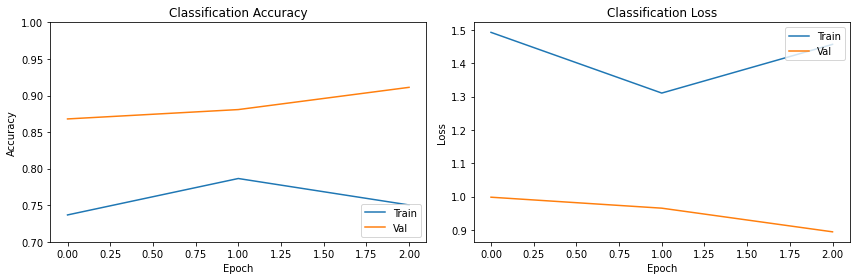

In [13]:
plot_history(history=history_Whole_Network, yrange=(0.7,1))

Interesting diagnostics hopefully the convolutional network will now be more adept at our specific task rather than imagenet but we want to drive up both the validation and training accuracy so we will now freeze those layers with the loaded weigths and train the lat part again.

# Load in weights trained on the whole model remove augmentation and try to run the model for 8 epochs


In [18]:
def create_model_with_weights(weights_path):

    conv_vgg16 = vgg16.VGG16(include_top=False, input_shape=(224, 224, 3) ) 
    inputs = conv_vgg16.input
    outputs = conv_vgg16.output
    
    conv_vgg16.trainable = False

    y = keras.layers.Flatten()(conv_vgg16.output)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(2000, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(0.001))(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(1000, activation='relu', kernel_initializer='he_uniform', activity_regularizer=tf.keras.regularizers.l1(0.001))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
    #model.summary()

    model.load_weights(weights_path)

    optim = keras.optimizers.Adam(lr=0.00005)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optim, 
                  metrics=['accuracy'])
    
    return model

In [16]:
# Must reduce batch size when training full network to avoide OOM error

# Redefine our generator functions:

def data_generators(preprocessing): 

    # All models we consider will have this target size requirement (VGG16, VGG19, and ResNet)
    target_size=(224,224)

    # define two separate imagegen's to allow for adding training augmentation arguements later.
    train_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing)
    
    
    # Seperate test gen so we don't augment test data. 
    test_imdatagen = ImageDataGenerator(preprocessing_function=preprocessing)


    train_dataset = train_imdatagen.flow_from_directory('birds/train',
                                            target_size= target_size, #all images should be 224x224 already but just in case
                                            class_mode= 'sparse', # changed from 'categorical' gives a label for each class from 0 - number of classes in a vector not one hot like categorical does
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=64
    )
    
    validation_dataset = test_imdatagen.flow_from_directory('birds/valid',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )
    
    test_dataset = test_imdatagen.flow_from_directory('birds/test',
                                            target_size= target_size,
                                            class_mode= 'sparse',
                                            color_mode = "rgb",
                                            seed = 118,
                                            batch_size=32      
    )


    return train_dataset, validation_dataset, test_dataset

In [17]:
# Call the data_generator function to create datasets with sparse labels

train_dataset, validation_dataset, test_dataset = data_generators(preprocessing=vgg16.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [19]:
full_model = create_model_with_weights('./BirdsSavedModels/WeightsOnly/Whole_Network_Trained1.h5')

# Fit our trained model with image augmentation. Increase Epochs
history_refreeze = full_model.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=10)

full_model.save_weights('./BirdsSavedModels/WeightsOnly/Refreeze.h5')
full_model.save('./BirdsSavedModels/FullModels/Refreeze.h5')

print('Saved Model!')


Epoch 1/10
551/551 [==============================] - 403s 731ms/step - loss: 1.1071 - accuracy: 0.8598 - val_loss: 0.8054 - val_accuracy: 0.9168
Epoch 2/10
551/551 [==============================] - 386s 701ms/step - loss: 0.8949 - accuracy: 0.9090 - val_loss: 0.7649 - val_accuracy: 0.9248
Epoch 3/10
551/551 [==============================] - 379s 688ms/step - loss: 0.7792 - accuracy: 0.9301 - val_loss: 0.7465 - val_accuracy: 0.9232
Epoch 4/10
551/551 [==============================] - 381s 692ms/step - loss: 0.6909 - accuracy: 0.9437 - val_loss: 0.7407 - val_accuracy: 0.9192
Epoch 5/10
551/551 [==============================] - 372s 675ms/step - loss: 0.6321 - accuracy: 0.9502 - val_loss: 0.7325 - val_accuracy: 0.9248
Epoch 6/10
551/551 [==============================] - 376s 683ms/step - loss: 0.

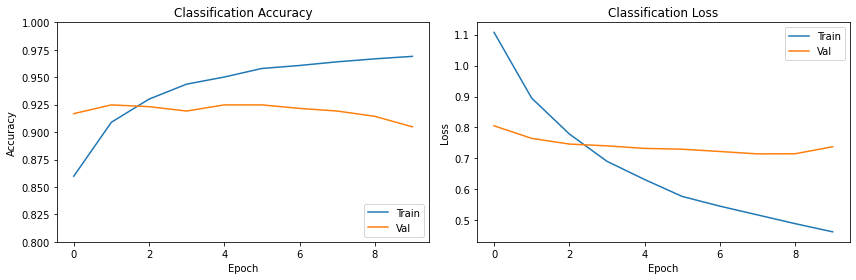

In [20]:
plot_history(history=history_refreeze, yrange=(0.8,1))

In [62]:
from keras import metrics
from keras import backend as K

## Define precision and recall

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [63]:
from keras import metrics

def create_model_with_weights(weights_path):

    conv_vgg16 = vgg16.VGG16(include_top=False, input_shape=(224, 224, 3) ) 
    inputs = conv_vgg16.input
    outputs = conv_vgg16.output
    
    conv_vgg16.trainable = False

    y = keras.layers.Flatten()(conv_vgg16.output)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # two hidden layers
    y = keras.layers.Dense(2000, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y=  keras.layers.Dropout(0.30)(y)
    y = keras.layers.Dense(1000, activation='relu', kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.30)(y)
    # final softmax layer 250 classes of birds
    pred_y = keras.layers.Dense(250, activation='softmax')(y)

    # creating the full model:
    model = keras.models.Model(inputs=conv_vgg16.input, outputs=pred_y)
    #model.summary()

    model.load_weights(weights_path)

    optim = keras.optimizers.Adam(lr=0.0001)
    # Configure the model training:
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optim, 
                  metrics=['accuracy', precision, recall])
    
    return model

In [65]:
full_model = create_model_with_weights('./BirdsSavedModels/WeightsOnly/Refreeze.h5')

# Fit our trained model with image augmentation. Increase Epochs
history_refreeze2 = full_model.fit ( train_dataset, validation_data = validation_dataset, workers = 10, epochs=3)

Epoch 1/3
551/551 [==============================] - 398s 722ms/step - loss: 0.1221 - accuracy: 0.9690 - precision: 1.0000 - recall: 0.9719 - val_loss: 0.2262 - val_accuracy: 0.9392 - val_precision: 1.0000 - val_recall: 0.9570
Epoch 2/3
551/551 [==============================] - 390s 708ms/step - loss: 0.0818 - accuracy: 0.9787 - precision: 1.0000 - recall: 0.9834 - val_loss: 0.2128 - val_accuracy: 0.9392 - val_precision: 1.0000 - val_recall: 0.9656
Epoch 3/3
551/551 [==============================] - 382s 693ms/step - loss: 0.0607 - accuracy: 0.9841 - precision: 1.0000 - recall: 0.9901 - val_loss: 0.2053 - val_accuracy: 0.9440 - val_precision: 1.0000 - val_recall: 0.9758


In [66]:
full_model.save_weights('./BirdsSavedModels/WeightsOnly/Refreeze2.h5')
full_model.save('./BirdsSavedModels/FullModels/Refreeze2.h5')

print('Saved Model!')

Saved Model!


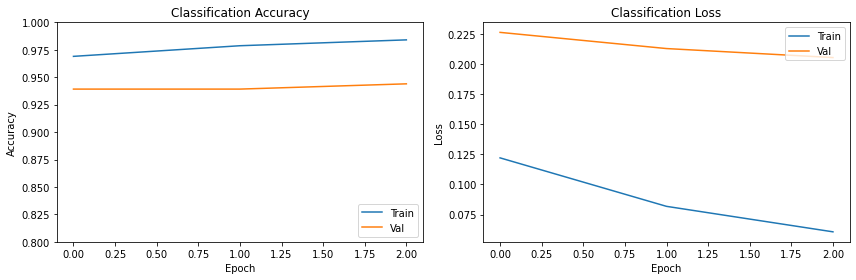

In [89]:
plot_history(history=history_refreeze2, yrange=(0.8,1))

## Import evalutaion metrics for precision and recall

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = full_model.predict(x_test, y_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(Y_pred, axis=1)

print(classification_report(test_dataset, y_pred_bool))

## or we can use the unbuilt metrics in Keras.

## Evalutate trained model on the test set:

In [81]:
final_model = create_model_with_weights('./BirdsSavedModels/WeightsOnly/Refreeze2.h5')


test_results = final_model.evaluate(test_dataset)
print(test_results)

40/40 [==============================] - 92s 2s/step - loss: 0.1262 - accuracy: 0.9616 - precision: 1.0000 - recall: 0.9805
[0.1262192577123642, 0.9616000056266785, 1.0, 0.98046875]


In [84]:
final_model = create_model_with_weights('./BirdsSavedModels/WeightsOnly/Refreeze2.h5')


test_results = final_model.evaluate(test_dataset)
print(test_results)


1250/1250 [==============================] - 86s 69ms/step - loss: 0.1262 - accuracy: 0.9616 - precision: 0.9800 - recall: 0.9800
[0.12621907889842987, 0.9616000056266785, 0.9799998998641968, 0.9799998998641968]


### Confusion Matrix and Model Metrics

In [85]:
# Confusion Matrix and Classification Report:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = final_model.predict(test_dataset, verbose=1)
y_pred_bool = np.argmax(Y_pred, axis=1)


1250/1250 [==============================] - 76s 61ms/step


In [87]:
test_x, test_y = test_dataset.next()

In [88]:
print('Confusion Matrix')
print(confusion_matrix(test_y, Y_pred))

print('Classification Report')
print(classification_report(test_y, y_pred_bool))

Confusion Matrix


ValueError: Found input variables with inconsistent numbers of samples: [1, 1250]

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

print('Confusion Matrix')
print(multilabel_confusion_matrix(test_dataset.classes, Y_pred))

Confusion Matrix


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [86]:
print('Classification Report')
print(classification_report(test_dataset, Y_pred))

Classification Report


ValueError: Expected array-like (array or non-string sequence), got <tensorflow.python.keras.preprocessing.image.DirectoryIterator object at 0x7fa5d12db518>

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))




In [45]:
Y_pred = final_model.predict(test_dataset, batch_size=32, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_dataset.classes, y_pred))

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=list(test_dataset.class_indices.keys())))

40/40 [==============================] - 182s 5s/step
Confusion Matrix


NameError: name 'test_datsaet' is not defined

In [52]:
print('Confusion Matrix')
print(confusion_matrix(test_dataset.classes, y_pred))

print('Classification Report')
print(classification_report(test_dataset.classes, y_pred, target_names=list(test_dataset.class_indices.keys())))

Confusion Matrix
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classification Report
                             precision    recall  f1-score   support

      AFRICAN CROWNED CRANE       0.00      0.00      0.00         5
          AFRICAN FIREFINCH       0.00      0.00      0.00         5
                  ALBATROSS       0.00      0.00      0.00         5
       ALEXANDRINE PARAKEET       0.00      0.00      0.00         5
            AMERICAN AVOCET       0.00      0.00      0.00         5
           AMERICAN BITTERN       0.00      0.00      0.00         5
              AMERICAN COOT       0.00      0.00      0.00         5
         AMERICAN GOLDFINCH       0.00      0.00      0.00         5
           AMERICAN KESTREL       0.00      0.00      0.00         5
             AMERICAN PIPIT       0.00      0.00      0.00         5
          AMERICAN REDSTART       0.00      0.00      0.00         5
            

## Using model test function to test some images:

This model suggests the image below is a:  Rock dove  with a probability of 99.98 %
____________________________________
The ground truth is:   ROCK DOVE
____________________________________

The two next most likely choices are: 
            Mourning dove with probability 0.01 % 
            Chukar partridge with probability 0.01 %
____________________________________


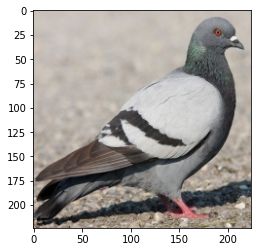

In [25]:
model_tester(full_model)

This model suggests the image below is a:  Dark eyed junco  with a probability of 95.9 %
____________________________________
The ground truth is:   DARK EYED JUNCO
____________________________________

The two next most likely choices are: 
            American pipit with probability 0.91 % 
            Pink robin with probability 0.57 %
____________________________________


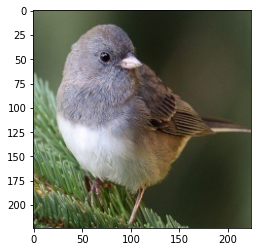

In [34]:
model_tester(final_model)

## Hope you enjoyed it!

*Any comments/corrections please email j.stelling@ncl.ac.uk*